### 참고
* https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html 
    * 텐서보드 튜토리얼
* https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html
    * 파이토치 빠른 시작
* https://tutorials.pytorch.kr/recipes/recipes/saving_and_loading_a_general_checkpoint.html
    * 체크포인트 저장
* https://tutorials.pytorch.kr/beginner/saving_loading_models.html
    * 모델 저장하기, 불러오기

In [6]:
import argparse
import yaml
import torch
import time

from torch.utils.tensorboard import SummaryWriter
from torch import nn

from utils.dataset import *
from utils.encoder import *
from nnet.CRNN import *
from utils.util import *

# from nnet.CRNN import CRNN

### 1. Argument 설정

In [7]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "-d", "--data", 
    default="MIVIA", 
    action="store",
    help="The dataset using training")

parser.add_argument(
    "-c", "--conf_file",
    default="./config/default.yaml", 
    help="The configuration file with all the experiment parameters.",
    )

parser.add_argument(
    "-m", "--mode",
    default="train", 
    help="train or test",
    )

parser.add_argument(
    "--gpu",
    default="0",
    type = int,
    help="The number of GPUs to train on, or the gpu to use, default='0', "
    "so uses one GPU",
)

parser.add_argument(
    "--test_from_checkpoint", default=None, help="Test the model specified"
)

# args = parser.parse_args()
args = parser.parse_args(["--data", "MIVIA", "--conf_file", "./config/default.yml", "-m" "train"])


In [8]:
with open(args.conf_file, "r") as f:
    conf = yaml.safe_load(f)

### 2. data configuration

In [9]:
encoder = multi_label_encoder(
    fs = conf['feats']['sample_rate'], 
    audio_len = conf['feats']['audio_len'], 
    n_fft = conf['feats']['n_fft'], 
    hop_length = conf['feats']['hop_length'], 
    net_pooling = conf['feats']['net_pooling']
    )

training_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_traindata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

test_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_testdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

validation_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_valdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )
# test_data = mivia(conf['data']['audio_folder'], conf['data']['xml_folder'], encoder, partition = conf['data']['select_testdata'], transform = MelSpectrogram_transform(conf['feats']))

In [10]:
print(MelSpectrogram_transform(conf['feats']))

MelSpectrogram(
  (spectrogram): Spectrogram()
  (mel_scale): MelScale()
)


### 3. device, hyperparameter, tensorboard configuration 

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# train, validation configuration
learning_rate = conf['opt']['lr'] # 1e-3
batch_size = conf['training']['batch_size']
epochs = conf['training']['n_epochs']
ckpt_dir = conf['training']['ckpt_path']
log_dir = conf['training']['log_path']

# save path(model) make
ckpt_dir = os.path.join(ckpt_dir, args.data + time.strftime('_%Y_%m_%d_%I_%M',time.localtime(time.time()))) # './checkpoint\\MIVIA_2022_07_26_11_26'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

# log path(tensorboard) make
if args.test_from_checkpoint is not None: # test tensorboard directory configuration
    log_dir = os.path.join(log_dir, os.path.basename(ckpt_dir), args.mode) # tensorboard directory
else: # training / validation tensorboard directory
    log_dir = os.path.join(log_dir, args.data + time.strftime('_%Y_%m_%d_%I_%M',time.localtime(time.time())), args.mode) # ./runs\MIVIA_2022_07_26_11_46\train

writer = SummaryWriter(log_dir = log_dir)

c:\anaconda3\envs\SED\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
  return f(*args, **kwds)


In [12]:
print(ckpt_dir)
print(log_dir)

./checkpoint\MIVIA_2022_08_19_01_01
./runs\MIVIA_2022_08_19_01_01\train


In [13]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)       # C, D
validation_dataloader = DataLoader(validation_data, batch_size, shuffle = True) # B
test_dataloader = DataLoader(test_data, 1, shuffle = False)             # A

In [14]:
print(len(train_dataloader))
print(len(train_dataloader.dataset))
print(len(validation_dataloader)) # batch size 수
print(len(validation_dataloader.dataset)) # 전체 sample 갯수
print(len(test_dataloader))
print(len(test_dataloader.dataset))

15
29
7
14
14
14


### 4. model, loss function, optimizer 정의

In [15]:
model = CRNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. train 정의

In [16]:
########################################################################################################################
#                                                         Train                                                        #
########################################################################################################################
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)  # 전체 training data의 size
    num_batches = len(dataloader)   # number of batch

    ## 테스트 더 할라면 여기다가 load 추가, if문이 좋음.

    model.train()

    running_loss = 0.0
    
    for batch_idx, (X, y) in enumerate(dataloader, 0): 
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X[:,:,:3750]) # [batch, frame, class]
        loss = loss_fn(pred, y)  

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss 기록
        running_loss += loss.item()

        print("Train : EPOCH %04d / %04d  | BATCH %04d | LOSS %.4f" %
              (epoch, conf['training']['n_epochs'], batch_idx, running_loss/(batch_idx+1)))

    running_loss = running_loss/num_batches #

    return running_loss



### 6. Validation
* 4가지 임시로 추가함

In [17]:
# 임시로 추가
def F1_score(mod, TF, t_test):

        TP = ((mod*TF) != 0).sum()
        TN = (( (torch.logical_not(mod.type(torch.bool)))*TF) != 0).sum()
        FP = ((mod*(torch.logical_not(TF.type(torch.bool)))) != 0).sum()
        FN = (((torch.logical_not(mod.type(torch.bool)))*(torch.logical_not(TF.type(torch.bool)))) != 0).sum()
        
        # G_noCC = torch.logical_not(mod[:,0].type(torch.bool))
        # G_noTS = torch.logical_not(mod[:,1].type(torch.bool))
        # T11 = ((mod[:,0]*t_test[:,0]) != 0).sum()
        # T12 = (((mod[:,1]*G_noCC)*t_test[:,0]) != 0).sum()
        # T13 = (((G_noCC*G_noTS)*t_test[:,0]) != 0 ).sum()
        # T21 = (((mod[:,0]*G_noTS)*t_test[:,1]) != 0).sum()
        # T22 = ((mod[:,1]*t_test[:,1]) != 0).sum()
        # T23 = (((G_noCC*G_noTS)*t_test[:,1]) != 0).sum()
        # T = [[T11,T12,T13],[T21,T22,T23]]

        P = torch.true_divide(TP,TP+FP + 0.00001)
        R = torch.true_divide(TP,TP+FN + 0.00001)
        F1 = torch.true_divide(2*P*R , P+R + 0.00001).item()
        # ER = torch.true_divide(FP+FN,TP+FN).item()
        # FPR = torch.true_divide(FP, FP+TN).item()
        # #pdb.set_trace()
        # acc = torch.true_divide(TP+TN , FP+FN+TP+TN).item()
        
        # Total = sum(sum(T, []))
        # RecRate = (T[0][0]+T[1][1]).item()/ Total.item()
        # MissRate = (T[0][2] + T[1][2]).item()/Total.item()
        # ErrorRate = (T[0][1] + T[1][0]).item()/Total.item()

        return F1

In [18]:
########################################################################################################################
#                                                      VALIDATION                                                      #
########################################################################################################################

def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    validation_loss, correct = 0, 0

    score = 0.0 #임시로 추가 1

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X[:,:,:3750])
            validation_loss += loss_fn(pred, y).item()
            correct = 0
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            ### 임시로 추가 2

            mod_binary = torch.ge(pred, 0.4)
            label_binary = torch.ge(y, 0.4)
            is_correct = torch.eq(mod_binary, label_binary)

            score += F1_score(mod_binary,is_correct,y)

            ### 임시로 추가 

    validation_loss /= num_batches
    correct /= size

    score /= num_batches # 임시로 추가 3

    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f}, f1: {score} \n")

    return validation_loss, score


    # # 임시로 추가 4
    # writer.add_scalar('f1', score, epoch)
    # #임시로 추가

    # print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f}, f1: {score} \n")

### 7. train & validation 실행

In [14]:
best_loss = 1000

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, epoch = t+1)
    validation_loss, score = validation(validation_dataloader, model, loss_fn)

    # tensor board
    writer.add_scalar('training loss', train_loss, t+1)
    writer.add_scalar('validation loss', validation_loss, t+1)

    # model save
    save(EPOCH = t+1, net = model, optimizer = optimizer, TRAIN_LOSS = train_loss, VAL_LOSS = validation_loss, PATH = ckpt_dir)
    if validation_loss < best_loss:

        best_loss = validation_loss
        save_best_model(f1score = score, EPOCH = t+1, net = model, optimizer = optimizer, TRAIN_LOSS = train_loss, VAL_LOSS = validation_loss, PATH = ckpt_dir)
        print(f"--------------------------------------------")
        
print("Done!")

Epoch 1
-------------------------------
Train : EPOCH 0001 / 0300  | BATCH 0000 | LOSS 0.6481
Train : EPOCH 0001 / 0300  | BATCH 0001 | LOSS 0.5797
Train : EPOCH 0001 / 0300  | BATCH 0002 | LOSS 0.5470
Train : EPOCH 0001 / 0300  | BATCH 0003 | LOSS 0.5249
Train : EPOCH 0001 / 0300  | BATCH 0004 | LOSS 0.5067
Train : EPOCH 0001 / 0300  | BATCH 0005 | LOSS 0.4932
Train : EPOCH 0001 / 0300  | BATCH 0006 | LOSS 0.4821
Train : EPOCH 0001 / 0300  | BATCH 0007 | LOSS 0.4719
Train : EPOCH 0001 / 0300  | BATCH 0008 | LOSS 0.4635
Train : EPOCH 0001 / 0300  | BATCH 0009 | LOSS 0.4545
Train : EPOCH 0001 / 0300  | BATCH 0010 | LOSS 0.4471
Train : EPOCH 0001 / 0300  | BATCH 0011 | LOSS 0.4395
Train : EPOCH 0001 / 0300  | BATCH 0012 | LOSS 0.4351
Train : EPOCH 0001 / 0300  | BATCH 0013 | LOSS 0.4308
Train : EPOCH 0001 / 0300  | BATCH 0014 | LOSS 0.4249
Validation Error: 
 Accuracy: 0.0%, Avg loss: 0.335251, f1: 0.0 

Epoch 1 에서 best model 저장
-------------------------------
---------------------------

KeyboardInterrupt: 

### 8. test

In [14]:
with open(args.conf_file, "r") as f:
    conf = yaml.safe_load(f)

In [15]:
conf['test']['ckpt_path'] = './checkpoint\MIVIA_2022_08_17_06_58'

In [16]:
########################################################################################################################
#                                                         TEST                                                         #
########################################################################################################################

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    ### 로드 추가(only model)
    model, _, _, _, _ = load_bestmodel(PATH = conf['test']['ckpt_path'], model = model, optimizer = optimizer, device = torch.device('cuda')) # best model

    model.eval()
    test_loss, correct = 0, 0

    score = 0.0 #임시로 추가 1

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device) # X : [batchsize, frequency, frame]
            pred = model(X[:,:,:3750]) #[batchsize, frame, class]
            test_loss += loss_fn(pred, y).item()

            # input feature visualization torch.ge(pred, 0.5)

            mod_binary = torch.ge(pred, 0.4)

            ### 임시로 추가 2
            mod_binary = torch.ge(pred, 0.4)
            label_binary = torch.ge(y, 0.4)
            is_correct = torch.eq(mod_binary, label_binary)
            score += F1_score(mod_binary,is_correct,y)
            ### 임시로 추가 

            
            
            
            

            # writer.add_image(f'spectrogram{i}', plot_spectrogram(X.cpu().squeeze(), title = f'{i}'))
            # writer.add_image(f'label{i}', matplotlib_label_show(y.cpu().squeeze(), title = f'label {i}'))
            # writer.add_image(f'prediction{i}', matplotlib_label_show(pred.detach().cpu().squeeze(), title = f'prediction {i}'))
            # writer.add_image(f'post{i}', matplotlib_label_show(mod_binary.detach().cpu().squeeze(), title = f'post {i}'))

            correct = 0
            # correct += (pred.argmax(1) == /y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    score /= num_batches # 임시로 추가 3


    # ...학습 중 손실(running loss)을 기록하고
    writer.add_scalar('test loss', test_loss)
    print(f"test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, f1 : {score} \n")

    return test_loss

In [17]:
test_loss = test(test_dataloader, model, loss_fn)
print(test_loss)

test Error: 
 Accuracy: 0.0%, Avg loss: 0.057525, f1 : 0.8722147984164101 

0.05752539860882929


### test 결과 시각화

In [18]:
import scipy

def matplotlib_label_show(target):
    n_frame = target.shape[0] # target.shape[0] = segment

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    x = np.arange(n_frame)  #(60,)
    y1 = target[:,0]        #(60,) 
    y2 = target[:,1]        #(60,) tire skidding
    y3 = target[:,2]        #(60,) car crash

    ax1.plot(x, y1, label = 'scream')
    ax1.plot(x, y2, label = 'tire skidding', color = 'orange')
    ax1.plot(x, y3, label = 'car crash', color = 'green')


    ax1.legend(framealpha = 1, loc = 'lower right', bbox_to_anchor=(1.4,0))
    # ax1.set_title('{}'.format(xmlfile))


    plt.show()


def median_filter(pred, median_window, thresholds):
    # pred : [batch, frame, class]
    pred = pred.squeeze() # [frame, class]
    post_filter = scipy.ndimage.filters.median_filter(pred.cpu().detach().numpy(), (median_window, 1)) # [frames, class]
    post_filter = (post_filter>thresholds).astype(float)
    
    return torch.Tensor(post_filter).unsqueeze(0)

In [19]:
spectrogram, label = next(iter(test_dataloader))

In [20]:
for i, (x, y) in enumerate(test_dataloader):
    if i == 3: 
        spectrogram = x
        label = y


        break

In [21]:
label = label.to(device)
spectrogram = spectrogram.to(device)

In [41]:
model, _, _, _, _ = load_bestmodel(PATH = conf['test']['ckpt_path'], model = model, optimizer = optimizer, device = torch.device('cuda'))

In [42]:
pred = model(spectrogram[:,:,:3750])

post = torch.ge(pred, 0.5)
post_filter = median_filter(pred, conf['test']['median_window'], conf['test']['threshold'])

In [43]:
print(pred.type, pred.device)
print(post.type, post.device)
print(post_filter.type, post_filter.device)
print(conf['test']['threshold'])

<built-in method type of Tensor object at 0x000002BFB92AD818> cuda:0
<built-in method type of Tensor object at 0x000002BFB8F36548> cuda:0
<built-in method type of Tensor object at 0x000002BFB92AD4F8> cpu
0.7


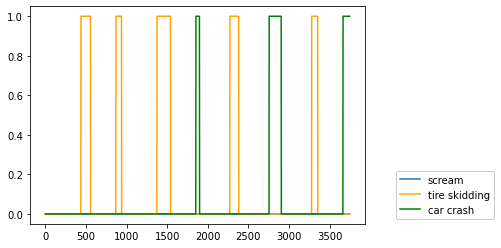

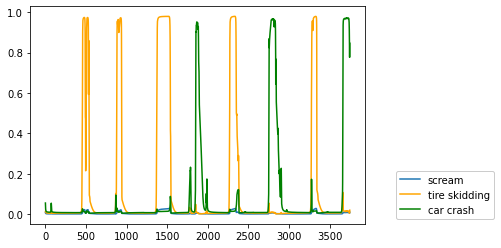

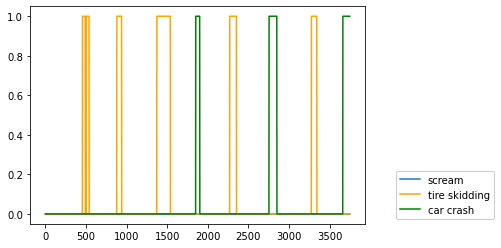

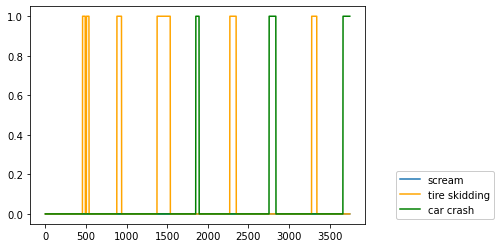

In [44]:
matplotlib_label_show(label.cpu().squeeze())
matplotlib_label_show(pred.detach().cpu().squeeze())
matplotlib_label_show(post.detach().cpu().squeeze())
matplotlib_label_show(post_filter.squeeze())


([<matplotlib.axis.YTick at 0x2bf8c3f9a48>,
 [Text(0, 0, 'scream'), Text(0, 1, 'tire'), Text(0, 2, 'crash')])

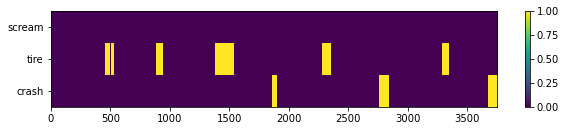

In [53]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 3)
plt.imshow(pred.cpu().detach().numpy().squeeze().T, aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(plt.imshow(pred_threshold.squeeze().T, aspect='auto', interpolation='nearest', cmap='viridis'))
plt.yticks([0, 1, 2], ['scream', 'tire', 'crash'])

### median filter test

In [26]:
type(pred)

torch.Tensor

In [27]:
pred_threshold = pred.detach().cpu().numpy() > conf['test']['threshold']

In [28]:
print(type(pred_threshold))
print(pred_threshold)
print(pred_threshold.shape)

<class 'numpy.ndarray'>
[[[False False False]
  [False False False]
  [False False False]
  ...
  [False False  True]
  [False False  True]
  [False False  True]]]
(1, 3750, 3)


In [29]:
pred_threshold_median = scipy.ndimage.filters.median_filter(pred_threshold.squeeze(), (7, 1))

In [30]:
print(pred_threshold_median)

[[False False False]
 [False False False]
 [False False False]
 ...
 [False False  True]
 [False False  True]
 [False False  True]]


In [45]:
print((pred_threshold == pred_threshold_median).all())
print(np.array_equal(pred_threshold_median, pred_threshold))
print(pred_threshold.shape)
print(type(pred_threshold))

False
False
(1, 3750, 3)
<class 'numpy.ndarray'>


### figure plot test

In [51]:
x, y= next(iter(test_dataloader))

label = y.to(device)
spectrogram = x.to(device)

In [52]:
model, _, _, _, _ = load_bestmodel(PATH = conf['test']['ckpt_path'], model = model, optimizer = optimizer, device = torch.device('cuda'))

pred = model(spectrogram[:,:,:3750])

post_filter = median_filter(pred, conf['test']['median_window'], conf['test']['threshold'])

In [54]:
spec = spectrogram.cpu().squeeze()
target = label.cpu().squeeze()
pred = pred.detach().cpu().squeeze()
post = post_filter.detach().cpu().squeeze()

In [60]:
n_frame = target.shape[0]
print(n_frame)

ylabel='freq_bin'
aspect='auto'
title = None
xmax = None

3750


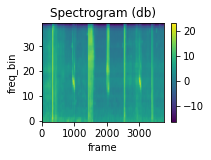

In [64]:
fig = plt.figure()

#spectrogram
ax1 = plt.subplot(221)
ax1.set_title(title or 'Spectrogram (db)')
ax1.set_ylabel(ylabel)
ax1.set_xlabel('frame')
im = ax1.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
if xmax:
    ax1.set_xlim((0, xmax))
fig.colorbar(im, ax=ax1)

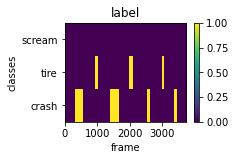

In [72]:
ax2 = plt.subplot(222)
ax2.set_title('label')
ax2.set_ylabel('classes')
ax2.set_xlabel('frame')
im = ax2.imshow(target.T, aspect='auto', interpolation='nearest', cmap='viridis')
plt.yticks([0, 1, 2], ['scream', 'tire', 'crash'])
fig.colorbar(im, ax=ax2)

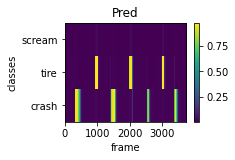

In [70]:
ax3 = plt.subplot(223)
ax3.set_title('Pred')
ax3.set_ylabel('classes')
ax3.set_xlabel('frame')
im = ax3.imshow(pred.T, aspect='auto', interpolation='nearest', cmap='viridis')
plt.yticks([0, 1, 2], ['scream', 'tire', 'crash'])
fig.colorbar(im, ax=ax3)

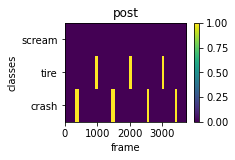

In [81]:
ax4 = plt.subplot(224)
ax4.set_title('post')
ax4.set_ylabel('classes')
ax4.set_xlabel('frame')
im = ax4.imshow(post.T, aspect='auto', interpolation='nearest', cmap='viridis')
plt.yticks([0, 1, 2], ['scream', 'tire', 'crash'])
fig.colorbar(im, ax=ax4)
plt.savefig(f'a.jpg', dpi=200)

In [80]:
plt.savefig(f'a.jpg', dpi=200)
plt.close()

<Figure size 432x288 with 0 Axes>

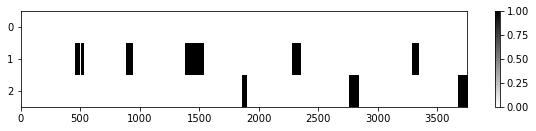

In [73]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 3)
plt.imshow(pred.T, aspect='auto', interpolation='nearest', cmap='gray_r')
plt.colorbar(plt.imshow(pred_threshold.squeeze().T, aspect='auto', interpolation='nearest', cmap='gray_r'))

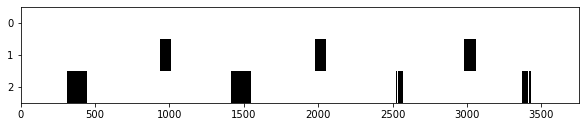

In [74]:
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 3)
plt.imshow(post.T, aspect='auto', interpolation='nearest', cmap='gray_r')

### NINA dataset으로 test

In [3]:
import torchaudio
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [44]:
class NINA(Dataset):
    def __init__(self, Audio_dir, transform = None, target_transform = None, pad_to = 60, fs = 44100):

        self.Audio_dir = Audio_dir
        self.resample_rate = fs # resampling rate
        self.pad_to = pad_to * self.resample_rate # unit of pad_to : [second]

        self.transform = transform
        self.target_transform = target_transform

        self.Audio_file_list = os.listdir(self.Audio_dir)


    def __len__(self):
        return len(self.Audio_file_list)  

    def __getitem__(self, idx):

        audio_data, _ = read_audio(os.path.join(self.Audio_dir, self.Audio_file_list[idx]), self.pad_to, self.resample_rate) # data load, fs = 32000(default)

        if self.transform: #data transform
            # transform. use this function to extract features in dataloader
            spectrogram = self.transform
            audio_data = spectrogram(audio_data) # [freq, frame]

        return audio_data

In [43]:
os.path.join('./data/nina/Audio', os.listdir('./data/nina/Audio')[0])

'./data/nina/Audio\\2mzHohHcvJk_64.0_74.0.wav'

In [30]:
os.listdir('./data/nina/Audio')

['2mzHohHcvJk_64.0_74.0.wav',
 '2mzHohHcvJk_179.0_189.0.wav',
 '2mzHohHcvJk_256.0_266.0.wav',
 '2mzHohHcvJk_74.0_84.0.wav',
 '2mzHohHcvJk_149.0_159.0.wav',
 '2mzHohHcvJk_45_0_55_0.wav',
 '2mzHohHcvJk_204.0_214.0.wav']

In [29]:
Audio_dir = './data/nina/Audio/2mzHohHcvJk_45_0_55_0.wav'
read_audio(Audio_dir, 10, 44100)

(tensor([-0.0025, -0.0056, -0.0084, -0.0113, -0.0147, -0.0184, -0.0219, -0.0255,
         -0.0305, -0.0367]),
 44100)

In [62]:
test_data = NINA(
    './data/nina/Audio', 
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    pad_to = 10,
    fs = 44100
    )

In [63]:
test_dataloader =  DataLoader(test_data, 1, shuffle=True)

In [64]:
x = next(iter(test_dataloader))

In [65]:
print(x.shape)

torch.Size([1, 128, 1723])


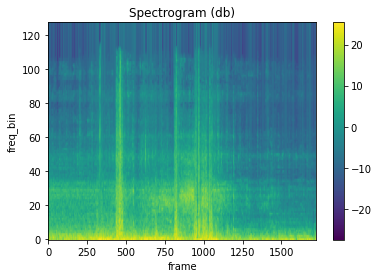

In [66]:
plot_spectrogram(x.squeeze())